# Unify Quantum Information Science and Quantum Machine Learning with Quantum Tensor Networks as modern diagrammatic reasoning on GPUs Cluster

Boring and waiting for NVIDIA cuQuantum appliance for multi-node-multi-gpu for Quantum Tensor Network, we skipped vector state simulation moved to __tensor network__ for quantum circuit simulation. It might be the future for design optimization algorithms and bridging gaps to understand correlated quantum systems more[1][2].

Tensor network may be fundamental building block of quantum information processing that connects computer science, condensed matter physics and mathematics[3].

With love on classical digital circuit for diagrammatic reasoning, some may be interested in quantum circuit and their graphical language for quantum engineering.

## Quantum Simulation PennyLane runing on GPU

### PennyLane Installation indirectly and easy with Docker

In [ ]:
PennyLane with cuQuantum:

Lightning-fast simulations with PennyLane and the NVIDIA cuQuantum SDK

Build from docker:
GitHub - PennyLaneAI/pennylane-lightning-gpu: GPU-enabled device for PennyLane

$ git clone https://github.com/PennyLaneAI/pennylane-lightning-gpu.git
$ cd pennylane-lightning-gpu
$ docker build . -f ./docker/Dockerfile -t "lightning-gpu-wheels"
Successfully tagged lightning-gpu-wheels:latest

$ docker run -v `pwd`:/io -it lightning-gpu-wheels cp -r ./wheelhouse /io
$ conda create -n pennylane python=3.8
$ conda activate pennylane

Check python version

$ python3 --version
$  python3 -m pip install ./wheelhouse/PennyLane_Lightning_GPU-0.27.0.dev1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
$ pip install cuquantum
$ conda activate quantum-computing
Benchmark Jacobian:
Lightning-fast simulations with PennyLane and the NVIDIA cuQuantum SDK[4]

### Verify we can running Quantum Circuit on A100 GPU
Having worked benchmarking quantum computing on GPUs, we learn NVIDIA cuQuantum SDK can applied on PennyLane framework[4].

In [1]:
import pennylane as qml
from timeit import default_timer as timer

# To set the number of threads used when executing this script,
# export the OMP_NUM_THREADS environment variable.

# Choose number of qubits (wires) and circuit layers
wires = 20
layers = 3

# Set number of runs for timing averaging
num_runs = 5

# Instantiate CPU (lightning.qubit) or GPU (lightning.gpu) device
dev = qml.device('lightning.gpu', wires=wires)


# Create QNode of device and circuit
@qml.qnode(dev, diff_method="adjoint")
def circuit(parameters):
    qml.StronglyEntanglingLayers(weights=parameters, wires=range(wires))
    return [qml.expval(qml.PauliZ(i)) for i in range(wires)]

# Set trainable parameters for calculating circuit Jacobian
shape = qml.StronglyEntanglingLayers.shape(n_layers=layers, n_wires=wires)
weights = qml.numpy.random.random(size=shape)

# Run, calculate the quantum circuit Jacobian and average the timing results
timing = []
for t in range(num_runs):
    start = timer()
    jac = qml.jacobian(circuit)(weights)
    end = timer()
    timing.append(end - start)

print(qml.numpy.mean(timing))

14.54812168199569


## Simulate Tensor-network on PennyLane framework with CPU

In [ ]:
!conda install -y matplotlib 

In [1]:
import pennylane as qml
from pennylane import numpy as np


def block(weights, wires):
    qml.RX(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

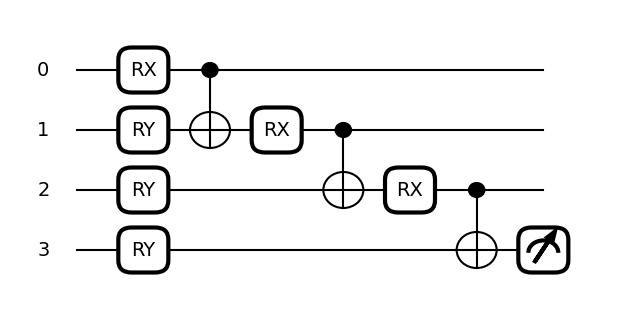

In [2]:
dev = qml.device("default.qubit", wires=4)


@qml.qnode(dev)
def circuit(template_weights):
    qml.MPS(
        wires=range(4),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))

np.random.seed(1)
weights = np.random.random(size=[3, 2])
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(weights)
fig.set_size_inches((6, 3))

## Apply tensor network quantum circuit to classifying the bars and stripes data set on GPU

If we have data set as vertical or horizontal strips, then let quantum simulation engine label the images as either bars or stripes. we want toy quantum circuit to prove of concept that we can then scale up to multi-node multi-GPU later.

For more detail at [5]. 

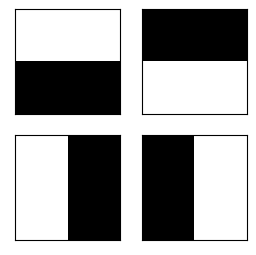

In [3]:
import matplotlib.pyplot as plt

BAS = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [0, 1, 0, 1]]
j = 1
plt.figure(figsize=[3, 3])
for i in BAS:
    plt.subplot(2, 2, j)
    j += 1
    plt.imshow(np.reshape(i, [2, 2]), cmap="gray")
    plt.xticks([])
    plt.yticks([])

In [4]:
def block(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)

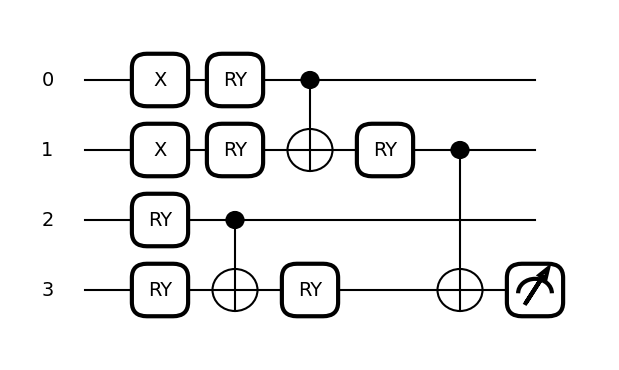

In [5]:
#dev = qml.device("default.qubit", wires=4)

dev = qml.device('lightning.gpu', wires=4)

@qml.qnode(dev)
def circuit(image, template_weights):
    qml.BasisStatePreparation(image, wires=range(4))
    qml.TTN(
        wires=range(4),
        n_block_wires=2,
        block=block,
        n_params_block=2,
        template_weights=template_weights,
    )
    return qml.expval(qml.PauliZ(wires=3))


weights = np.random.random(size=[3, 2])
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(BAS[0], weights)
fig.set_size_inches((6, 3.5))

In [6]:
def costfunc(params):
    cost = 0
    for i in range(len(BAS)):
        if i < len(BAS) / 2:
            cost += circuit(BAS[i], params)
        else:
            cost -= circuit(BAS[i], params)
    return cost

In [7]:
params = np.random.random(size=[3, 2], requires_grad=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.1)

for k in range(100):
    if k % 20 == 0:
        print(f"Step {k}, cost: {costfunc(params)}")
    params = optimizer.step(costfunc, params)

Step 0, cost: -0.4109040373994175
Step 20, cost: -3.999999106074138
Step 40, cost: -3.9999999999999996
Step 60, cost: -4.000000000000001
Step 80, cost: -3.999999999999999


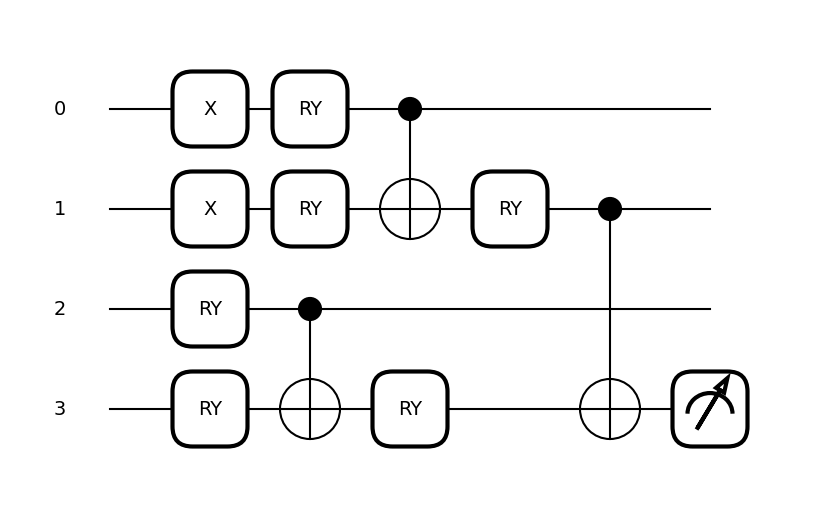

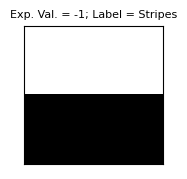

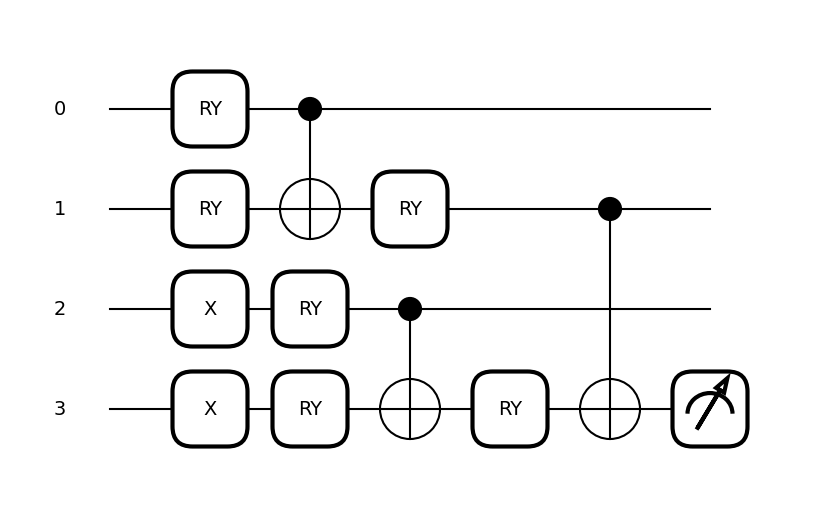

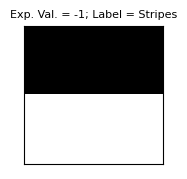

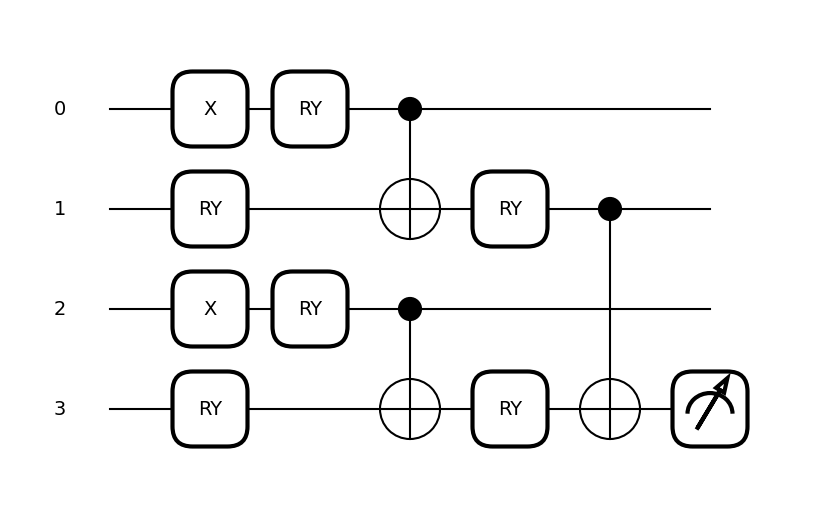

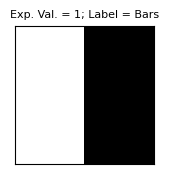

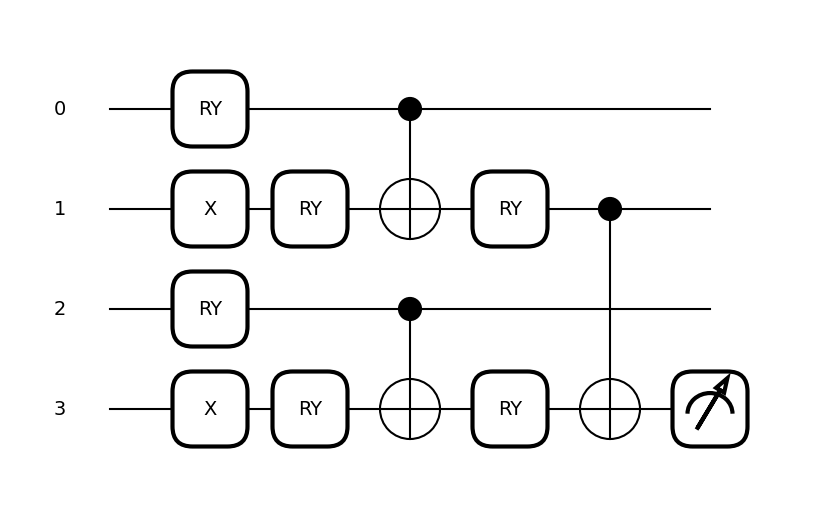

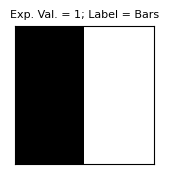

In [8]:
for image in BAS:
    fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(image, params)
    plt.figure(figsize=[1.8, 1.8])
    plt.imshow(np.reshape(image, [2, 2]), cmap="gray")
    plt.title(
        f"Exp. Val. = {circuit(image,params):.0f};"
        + f" Label = {'Bars' if circuit(image,params)>0 else 'Stripes'}",
        fontsize=8,
    )
    plt.xticks([])
    plt.yticks([])

Reference:

1. Quantum Tensor Networks and Entanglement 
https://cordis.europa.eu/project/id/647905

2.Achieving Supercomputing-Scale Quantum Circuit Simulation with the NVIDIA DGX cuQuantum Appliance
https://developer.nvidia.com/blog/achieving-supercomputing-scale-quantum-circuit-simulation-with-the-dgx-cuquantum-appliance/

3. Lectures on Quantum Tensor Networks, Jacob Biamonte
https://arxiv.org/abs/1912.10049

4. Lightning-fast simulations with PennyLane and the NVIDIA cuQuantum SDK
https://pennylane.ai/blog/2022/07/lightning-fast-simulations-with-pennylane-and-the-nvidia-cuquantum-sdk/

5. Tensor-network quantum circuits
https://pennylane.ai/qml/demos/tutorial_tn_circuits.html
